# <center style='color:tan'> Variational AutoEncoder (VAE) - Example using USPS dataset </center>

## 1. Import the libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt

## 2. Define the device

In [2]:
print('PyTorch version:', torch.__version__, '\n')
print('GPU name:', torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is:', device, '\n')
print('Total number of GPUs:', torch.cuda.device_count())

PyTorch version: 2.0.1+cu117 

GPU name: NVIDIA RTX A5000 

Device is: cuda 

Total number of GPUs: 1


## 3. load USPS dataset

In [3]:
training_dataset = datasets.USPS('./data_src', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.USPS('./data_src', train=False, download=True, transform=transforms.ToTensor())

100%|███████████████████████████████████████████████| 6579383/6579383 [00:00<00:00, 18716212.55it/s]


100%|████████████████████████████████████████████████| 1831726/1831726 [00:00<00:00, 6359072.92it/s]


In [4]:
# check the length of training and test datasets

print('Length of the training dataset:', len(training_dataset))
print('Length of the test dataset:', len(test_dataset))

Length of the training dataset: 7291
Length of the test dataset: 2007


#### In total, there are `7291 samples (images)` in the `training set` and `2007 samples (images)` in the `test set`

In [5]:
# check the shape of training and test datasets

print('Shape of the training dataset:', training_dataset.data.shape)
print('Shape of the test dataset:', test_dataset.data.shape)

Shape of the training dataset: (7291, 16, 16)
Shape of the test dataset: (2007, 16, 16)


Shape: (total images, height, width)

#### The `spatial dimension` of the `grayscale images` in the `USPS dataset` is `16x16` pixels

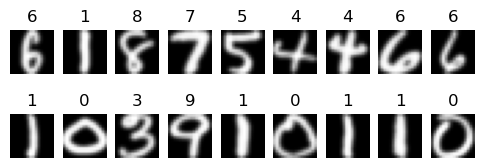

In [6]:
# show 18 randomly selected samples from the training dataset

fig, axis = plt.subplots(nrows=2, ncols=9, figsize=(6, 2))

for ax, _ in zip(axis.ravel(), range(18)):
    inx = np.random.randint(len(training_dataset))
    ax.imshow(training_dataset.data[inx], cmap='Greys_r')
    ax.set_title(training_dataset.targets[inx], fontsize=12)
    ax.axis(False);

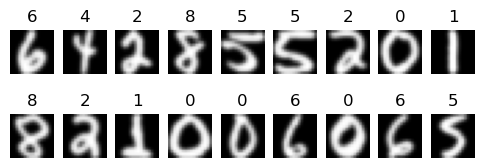

In [7]:
# show 18 randomly selected samples from the test dataset

fig, axis = plt.subplots(nrows=2, ncols=9, figsize=(6, 2))

for ax, _ in zip(axis.ravel(), range(18)):
    inx = np.random.randint(len(test_dataset))
    ax.imshow(test_dataset.data[inx], cmap='Greys_r')
    ax.set_title(test_dataset.targets[inx], fontsize=12)
    ax.axis(False);

## 4. Define dataloaders

In [8]:
training_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

In [9]:
# check the length of training and test dataloaders

print('Length of the training dataloader:', len(training_dataloader))
print('Length of the test dataloader:', len(test_dataloader))

Length of the training dataloader: 227
Length of the test dataloader: 62


Since, neither 7291 nor 2007 is divisible by 32; the last batch will not have 32 images in it and hence I dropped it. 227 and 62 are showing the number of batches in training and test dataloaders, respectively.

#### Dataloader converts a dataset into an iterable

## 5. Define the network architecture

In [10]:
class Conv_VAE(nn.Module):
    def __init__(self):
        super(Conv_VAE, self).__init__()
        
        self.encoder = nn.Sequential()
        self.encoder.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2))
        self.encoder.add_module('bnorm1', nn.BatchNorm2d(num_features=16))
        self.encoder.add_module('relu1', nn.ReLU(inplace=True))
        self.encoder.add_module('conv2', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2))
        self.encoder.add_module('relu2', nn.ReLU(inplace=True))
        self.encoder.add_module('conv3', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2))
        self.encoder.add_module('relu3', nn.ReLU(inplace=True))
        
        self._mu = nn.Linear(in_features=64, out_features=16)
        self._logvar = nn.Linear(in_features=64, out_features=16)
        
        self.decoder = nn.Sequential()
        self.decoder.add_module('tconv3', nn.ConvTranspose2d(in_channels=16, out_channels=32, kernel_size=3, stride=2))
        self.decoder.add_module('relu3', nn.ReLU(inplace=True))
        self.decoder.add_module('tconv2', nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=3, stride=2))
        self.decoder.add_module('relu2', nn.ReLU(inplace=True))
        self.decoder.add_module('tconv1', nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2))
        self.decoder.add_module('sigmoid1', nn.Sigmoid())
        
    def reparameterization(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.rand_like(std)
        sampling = mu + (eps * std)
        return sampling
        
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.shape[0], -1)
        
        mu = self._mu(x)
        logvar = self._logvar(x)
        
        x = self.reparameterization(mu, logvar)
        x = x.view(-1, 16, 1, 1)
        
        return self.decoder(x), mu, logvar

In `Conv_VAEs`, `Encoder` block outputs two vectors: `mu` and `logvar`. These two vectors are two distributions basically. From these two distributions, latent space is sampled as a __Gaussian distribution__.

## 6. Visualize the model architecture

In [11]:
model = Conv_VAE().to(device)
summary(model, input_size=(32, 1, 16, 16))

Layer (type:depth-idx)                   Output Shape              Param #
Conv_VAE                                 [32, 1, 16, 16]           --
├─Sequential: 1-1                        [32, 64, 1, 1]            --
│    └─Conv2d: 2-1                       [32, 16, 7, 7]            160
│    └─BatchNorm2d: 2-2                  [32, 16, 7, 7]            32
│    └─ReLU: 2-3                         [32, 16, 7, 7]            --
│    └─Conv2d: 2-4                       [32, 32, 3, 3]            4,640
│    └─ReLU: 2-5                         [32, 32, 3, 3]            --
│    └─Conv2d: 2-6                       [32, 64, 1, 1]            18,496
│    └─ReLU: 2-7                         [32, 64, 1, 1]            --
├─Linear: 1-2                            [32, 16]                  1,040
├─Linear: 1-3                            [32, 16]                  1,040
├─Sequential: 1-4                        [32, 1, 16, 16]           --
│    └─ConvTranspose2d: 2-8              [32, 32, 3, 3]            4,64

## 7. Define the training batch

In [12]:
def training_batch(data, model, optimizer, loss_fucntion):
    model.train()
    data = data.to(device)
    recon, mu, logvar = model(data)
    loss = loss_function(recon, data, mu, logvar)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

## 8. Define the test batch

In [13]:
with torch.inference_mode():
    def test_batch(data, model, loss_function):
        model.eval()
        data = data.to(device)
        recon, mu, logvar = model(data)
        loss = loss_function(recon, data, mu, logvar)
        return loss

## 9. Set up model (`VAE`), criterion (`loss function`) and optimizer

In [14]:
def loss_function(recon, x, mu, logvar):
    RECON = F.mse_loss(recon, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return RECON + KLD

In [15]:
conv_vae = Conv_VAE().to(device)
optimizer = optim.Adam(conv_vae.parameters(), lr=0.001)

## 10. Train the model

In [16]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

n_epochs = 100

training_loss, test_loss = [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []
    
    for data, _ in training_dataloader:
        trng_batch_loss = training_batch(data, conv_vae, optimizer, loss_function)
        training_losses.append(trng_batch_loss.item())
    training_per_epoch_loss = np.array(training_losses).mean()
    
    for data, _ in test_dataloader:
        tst_batch_loss = test_batch(data, conv_vae, loss_function)
        test_losses.append(tst_batch_loss.item())
    test_per_epoch_loss = np.array(test_losses).mean()
    
    training_loss.append(training_per_epoch_loss)
    test_loss.append(test_per_epoch_loss)
    
    if (epoch+1) % 10==0:
        print(f'Epoch: {epoch+1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} |   ', end='')
        print(f'Test loss: {test_per_epoch_loss:.4f}')

Epoch: 10/100	| Training loss: 194.0327 |   Test loss: 204.5845
Epoch: 20/100	| Training loss: 176.1108 |   Test loss: 186.4528
Epoch: 30/100	| Training loss: 170.9685 |   Test loss: 185.0497
Epoch: 40/100	| Training loss: 165.8475 |   Test loss: 175.2436
Epoch: 50/100	| Training loss: 162.9278 |   Test loss: 179.4127
Epoch: 60/100	| Training loss: 160.1693 |   Test loss: 180.1335
Epoch: 70/100	| Training loss: 159.1966 |   Test loss: 171.8023
Epoch: 80/100	| Training loss: 157.8040 |   Test loss: 170.6463
Epoch: 90/100	| Training loss: 156.3871 |   Test loss: 170.2617
Epoch: 100/100	| Training loss: 155.5479 |   Test loss: 168.6910


I trained the `Conv_VAE` model for `100 epochs` only. However, you can obviously train it for a longer period of time and observe if the performance gets better or not! 

## 11. Plot model loss

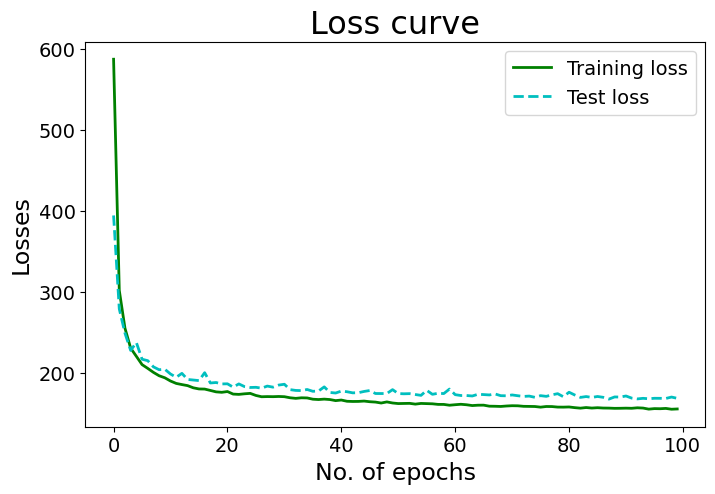

In [17]:
plt.figure(figsize=(8, 5))

plt.plot(training_loss, 'g-', linewidth=2, label='Training loss')
plt.plot(test_loss, 'c--', linewidth=2, label='Test loss')
plt.title('Loss curve', fontsize=23)
plt.xlabel('No. of epochs', fontsize=17)
plt.ylabel('Losses', fontsize=17)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14);

## 12. Model prediction

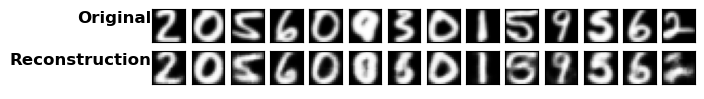

In [18]:
ORG, REC = [], []

for a in range(14):
    idx = np.random.randint(len(test_dataset))
    ORG.append(test_dataset[idx][0])
    REC.append(conv_vae.cpu()(ORG[a].unsqueeze(0))[0])
    
fig, ax = plt.subplots(nrows=2, ncols=14, figsize=(7, 1))

for i in range(14):
    ax[0, i].imshow(ORG[i].squeeze(), cmap='Greys_r')
    ax[0, i].set_xticks([])
    ax[0, i].set_yticks([])
    ax[1, i].imshow(REC[i].squeeze().cpu().detach().numpy(), cmap='Greys_r')
    ax[1, i].set_xticks([])
    ax[1, i].set_yticks([])

ax[0, 0].set_ylabel('Original', fontsize=12, rotation=0, labelpad=24, fontweight='bold')
ax[1, 0].set_ylabel('Reconstruction', fontsize=12, rotation=0, labelpad=48, fontweight='bold');

We randomly selected 14 images from the test set and checked the corresponding `reconstruction` provided by the `Conv_VAE` model.

It's very difficult to understand but if you closely look, you can notice that the reconstructed images are much better in this case compared to what we got using `VAE` model in the previous video. Nevertheless, there are fine differences between the original and reconstructed images. Moreover, The sixth and seventh reconstructed images in the above picture don't look very similar to their original equivalents.

## 13. Create samples from noise vectors

In [19]:
conv_vae.decoder

Sequential(
  (tconv3): ConvTranspose2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (relu3): ReLU(inplace=True)
  (tconv2): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (relu2): ReLU(inplace=True)
  (tconv1): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
  (sigmoid1): Sigmoid()
)

The size of the `input_vector` to the decoder will have to be: `(16, 1, 1)` ===> `(C, H, W)`.

In [20]:
with torch.inference_mode():
    noise_vecs = torch.randn(180, 16, 1, 1)
    sampled = conv_vae.decoder(noise_vecs)
    gen_imgs = make_grid(sampled, nrow=18).permute(1, 2, 0)

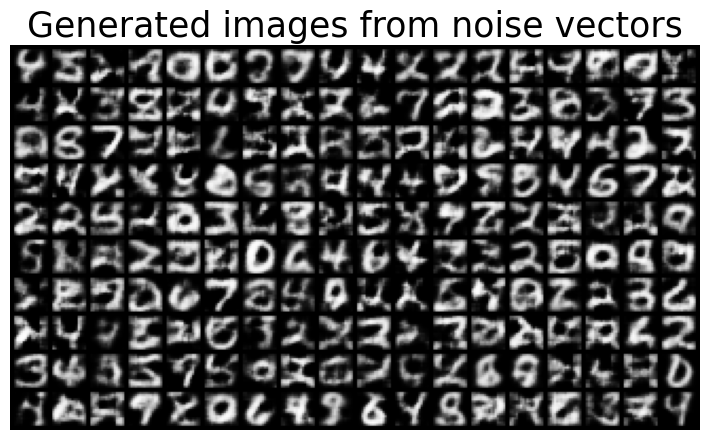

In [21]:
plt.figure(figsize=(12, 5))
plt.imshow(gen_imgs, cmap='Greys_r')
plt.title('Generated images from noise vectors', fontsize=25)
plt.axis(False);

We generated 180 images from noise vectors. They simply don't look good after 100 epochs. So, the model needs to be trained for higher number of epochs.